# Model Interpretability

In [1]:
from IPython.core.interactiveshell import InteractiveShell # 모든 명령어 출력
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML # 화면 좌우 크기 100%
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings # 파이썬 버전에 따른 오류 출력 방지
warnings.filterwarnings('ignore')

import pandas as pd # pandas
import numpy as np # numphy
import matplotlib.pyplot as plt # 시각화 matplob
import seaborn as sns; sns.set() # 시각화 seaborn
get_ipython().run_line_magic('matplotlib', 'inline') # 시각화 그림 자동 화면 출력
plt.rcParams['font.family'] = 'Malgun Gothic'  # 한글 표시
plt.rcParams['axes.unicode_minus'] = False  #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [19]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns= data.feature_names)
y = data.target
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=11)

LogisticRegression()

<AxesSubplot:xlabel='variable'>

Text(0.5, 1.0, '로지스틱회귀모형의 특성변수 중요도')

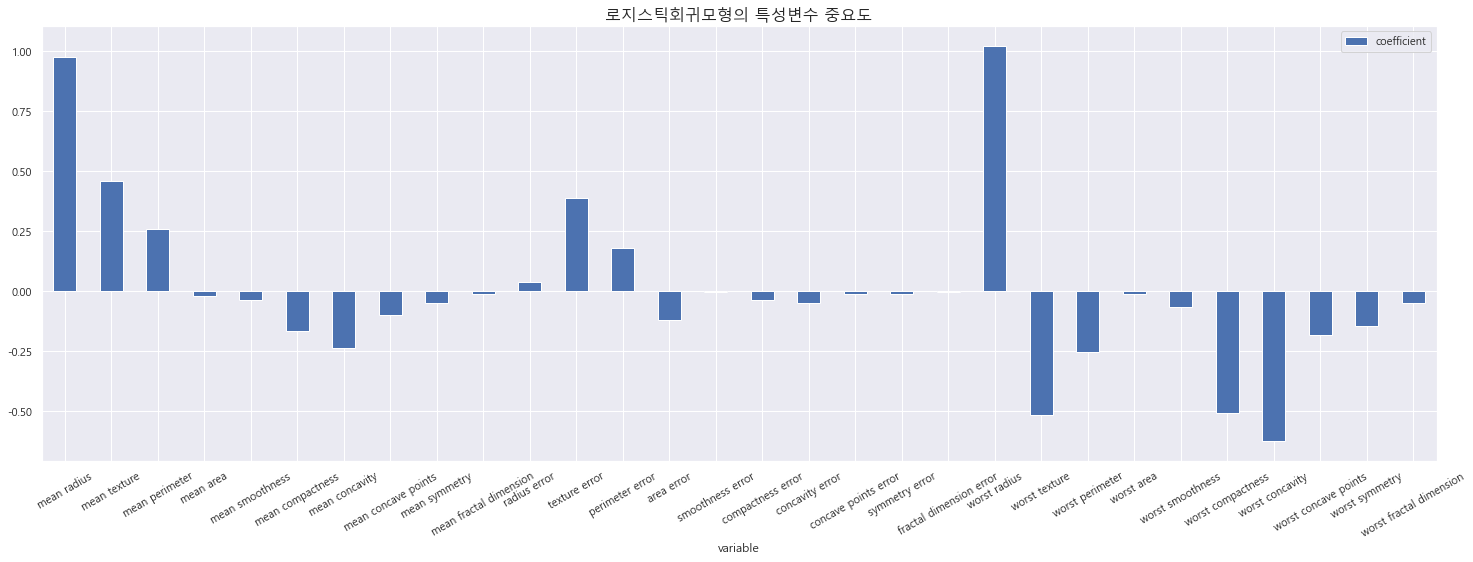

In [20]:
from sklearn.linear_model import LogisticRegression
lgr = LogisticRegression()
lgr.fit(X_train, y_train)
data = zip(X_train.columns, np.squeeze(lgr.coef_))
(pd.DataFrame(data, columns =['variable', 'coefficient']).set_index('variable').
plot.bar(rot='30', figsize=(25,8)))
plt.title('로지스틱회귀모형의 특성변수 중요도', fontsize=16)

## 1. 특성변수 model-based 중요도

랜덤포레스트 모델의 입력변수의 중요도를 X축으로 하여 변수명을 시각화
- '연령’, ‘모바일 평일 이용시간’, ‘모바일 주말 이용시간’ 등이 예측에 크게 영향을 미치고 있다.

RandomForestClassifier(class_weight='balanced')

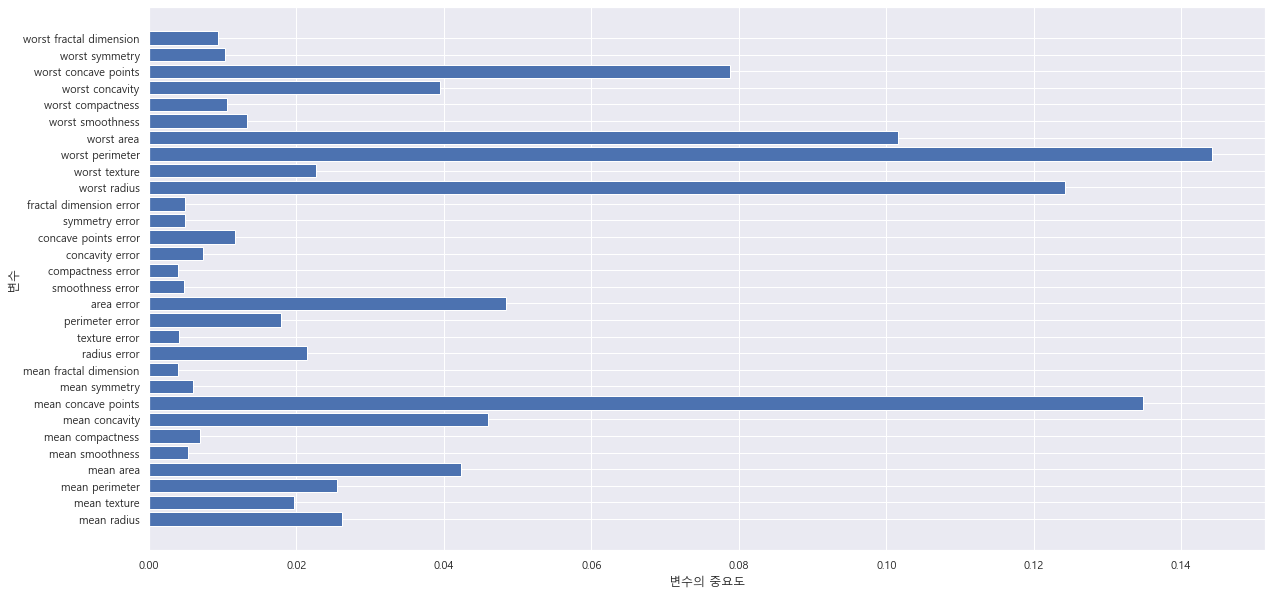

In [21]:
from sklearn.ensemble import (BaggingClassifier, RandomForestClassifier) 
rf = RandomForestClassifier(class_weight='balanced', n_estimators=100)
rf.fit(X_train, y_train)
def plot_feature_importances(model):
    fig, ax = plt.subplots(1,1,figsize=(20,10))
    plt.barh(range(X_train.shape[1]), rf.feature_importances_, align='center')
    plt.yticks(np.arange(X_train.shape[1]), X_train.columns)
    plt.xlabel('변수의 중요도')
    plt.ylabel('변수')
    #plt.savefig('../../output/Feature_importance') # 그림 파일 저장
plot_feature_importances(rf)

## 2. 특성변수 permutation-based 중요도

- 특정 변수의 값을 무작위로 재정렬하여(permutation) 학습하는 경우 모델의 정확도에 영향을 얼마나 주는지를 가리키는 지표
     * model_based’ 중요도의 크기와는 다르다. 사이킷런의 Permutation-based feature importance모듈을 호출
- 예측에 영향을 미치는 입력변수의 중요도가 높은 순서대로 확인

result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(12, 10))
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

<AxesSubplot:xlabel='0'>

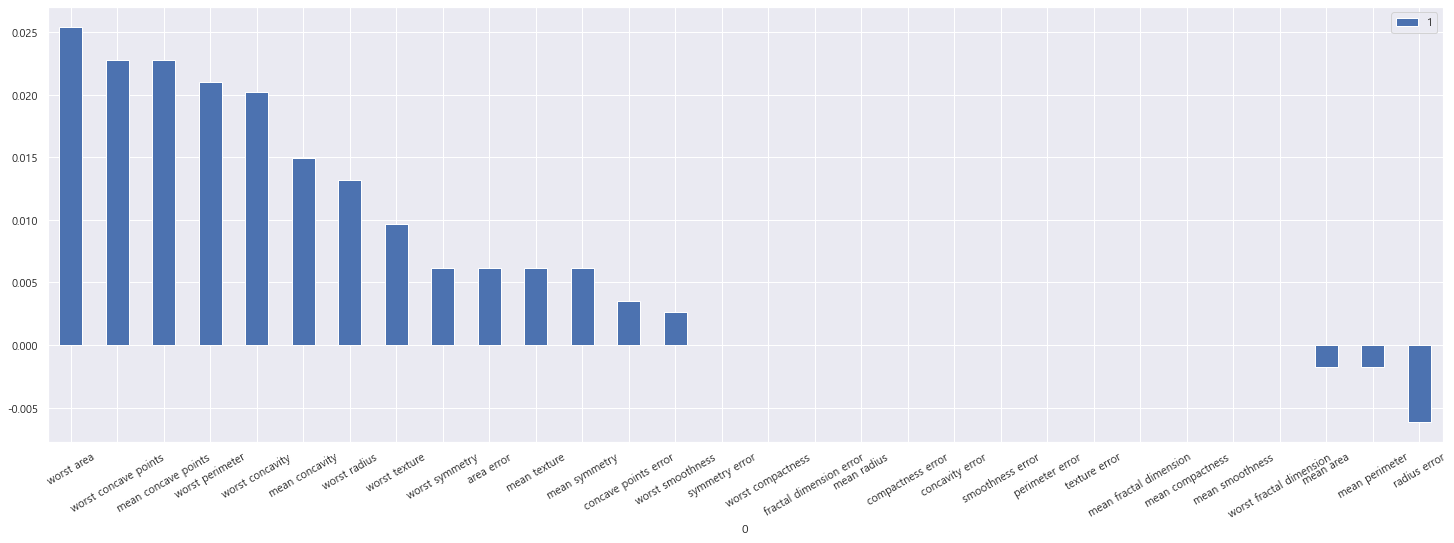

In [22]:
from sklearn.inspection import permutation_importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=0)
#result.importances_mean.round(4)
#np.argsort(result.importances_mean)
data = pd.DataFrame(list(zip(X_train.columns, result.importances_mean)))
data.sort_values(by =1, ascending= False, inplace =True)
data.plot(kind='bar', x=0, y=1, rot='30', figsize=(25, 8))

## 3. 특성변수 영향도(partial dependence)

- 사이킷런의 feature importance와 permutation importance는 예측에 영향을 미치는 상대적 중요도를 나타낸다. 
- pdp는 예측 확률에 어떻게 영향을 미치는지를 보여준다. 
- 전체 입력변수의 상대적인 중요도가 아닌 개별 변수의 민감도

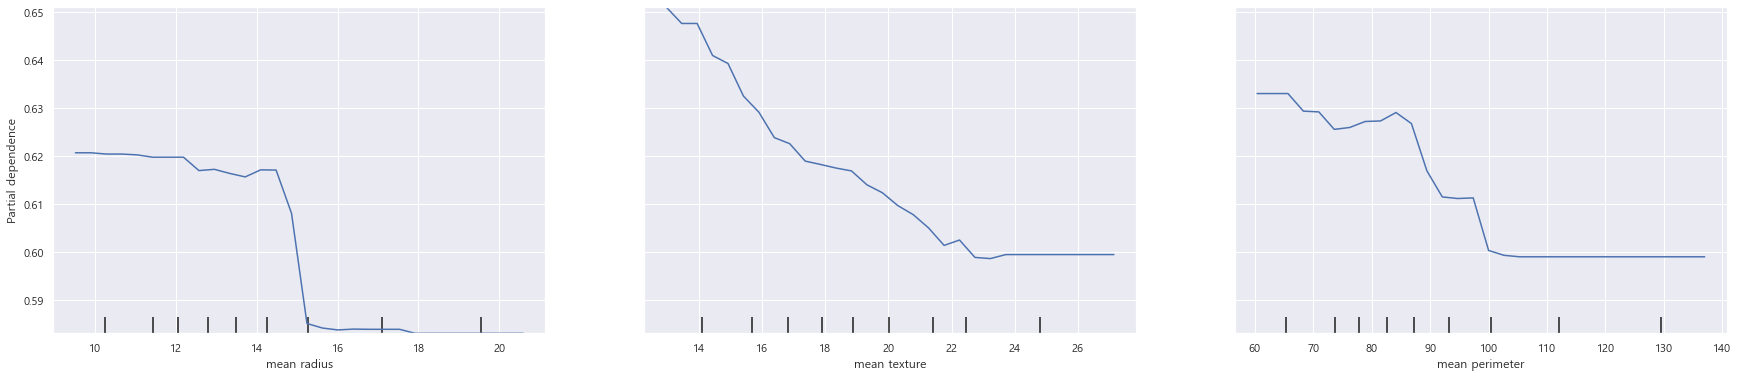

In [23]:
from sklearn.inspection import plot_partial_dependence
plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
plt.rcParams['figure.figsize'] = (30,6)
features = ['mean radius', 'mean texture', 'mean perimeter']
plot_partial_dependence(rf, X_train, features, n_jobs=3, grid_resolution=30)
fig = plt.gcf(); fig.subplots_adjust(hspace=2)

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='mean radius'>})

(<Figure size 1080x684 with 2 Axes>,
 {'title_ax': <AxesSubplot:>, 'pdp_ax': <AxesSubplot:xlabel='mean texture'>})

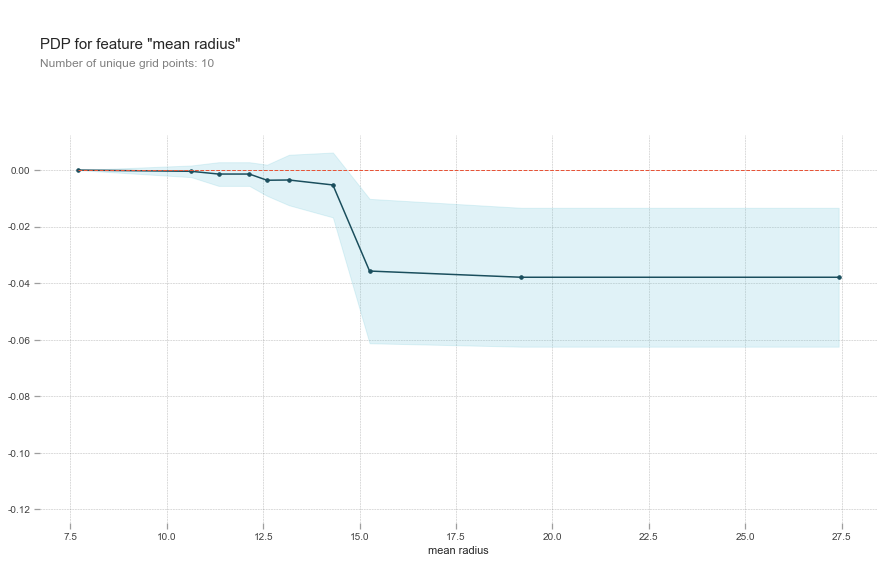

In [ ]:
from pdpbox import pdp, get_dataset, info_plots # pip install pdpbox
for i in ['mean radius', 'mean texture'] :
    pdp_goals = pdp.pdp_isolate(model=rf, dataset=X_test, 
                               model_features=X_test.columns, feature=i)
    pdp.pdp_plot(pdp_goals, i)

In [2]:
from IPython.display import Image
width=800; height=500
dir_path = r'D:\ASSIST\img'

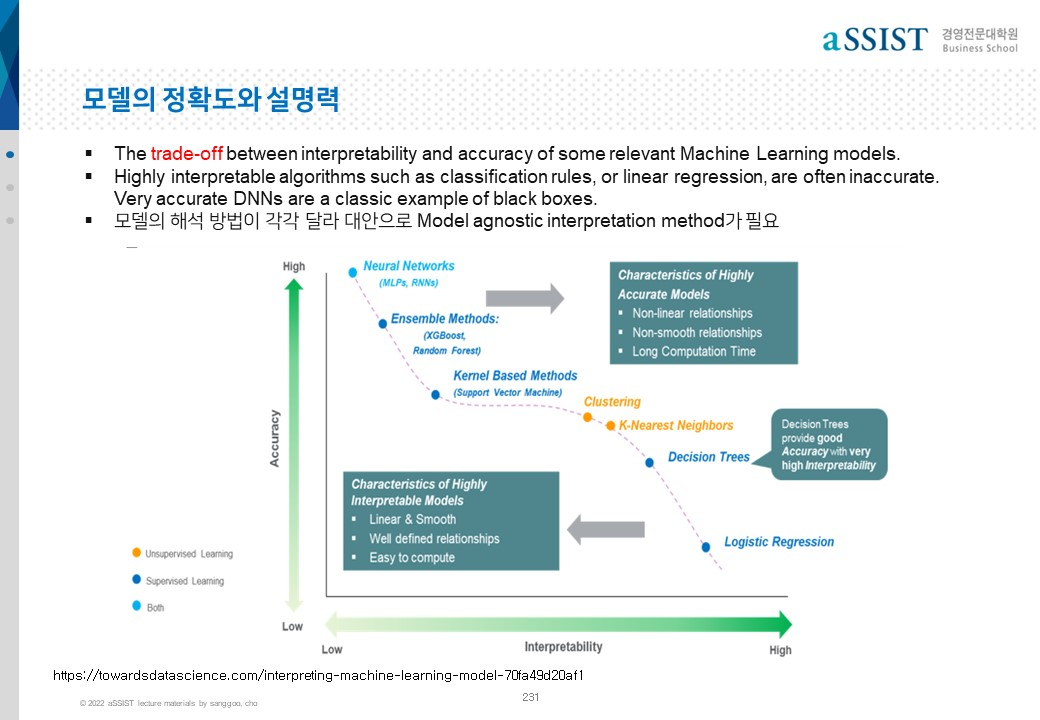

In [3]:
Image(filename=dir_path + '/슬라이드231.jpg', width=width, height=height)

SHAP 설명 (참고)
- permutaion based importance와 비교(장담점)
- https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values

# 4. SHAP (Shapley value additivity model)
## 모델 불가지론(model agnostic)
https://github.com/slundberg/shap (설명은 여기를 보고)
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html (그림그리기는 여기를)

<img src='https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7326367/bin/nihms-1601475-f0004.jpg'>

### the “game” is reproducing the outcome of the model,
### the “players” are the features included in the model.
### What Shapley does is quantifying the contribution that each player(feature) brings to the game(model).
<img src='https://miro.medium.com/max/1540/1*wOLS6BO2vGTSB4sCoAb6fQ.png'>

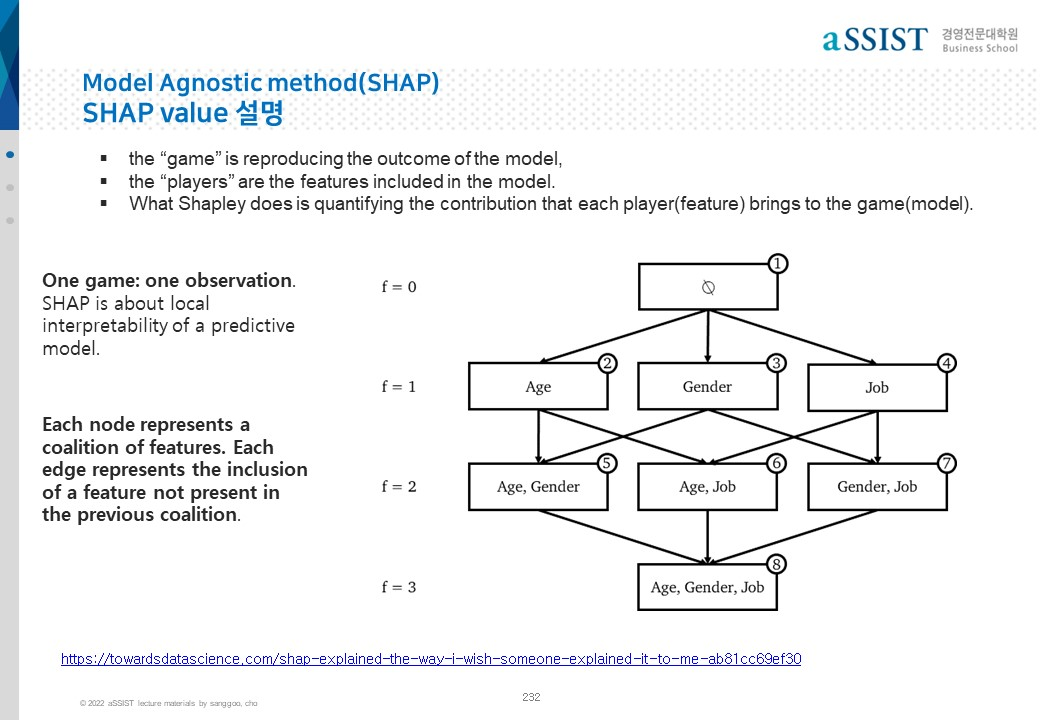

In [4]:
Image(filename=dir_path + '/슬라이드232.jpg', width=width, height=height)

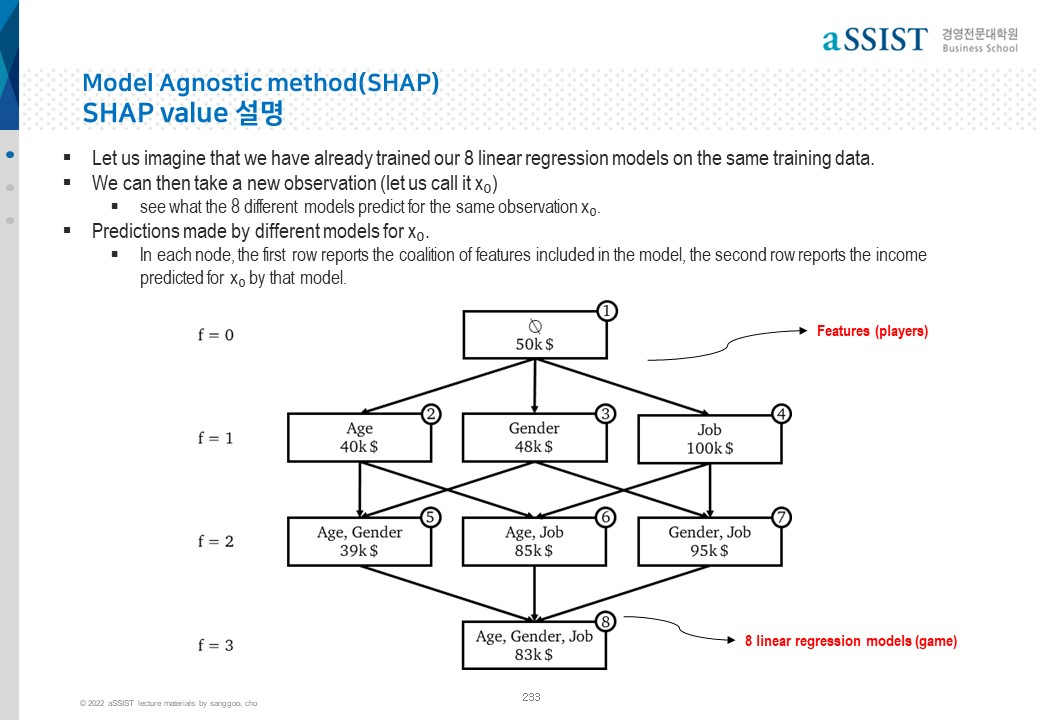

In [5]:
Image(filename=dir_path + '/슬라이드233.jpg', width=width, height=height)

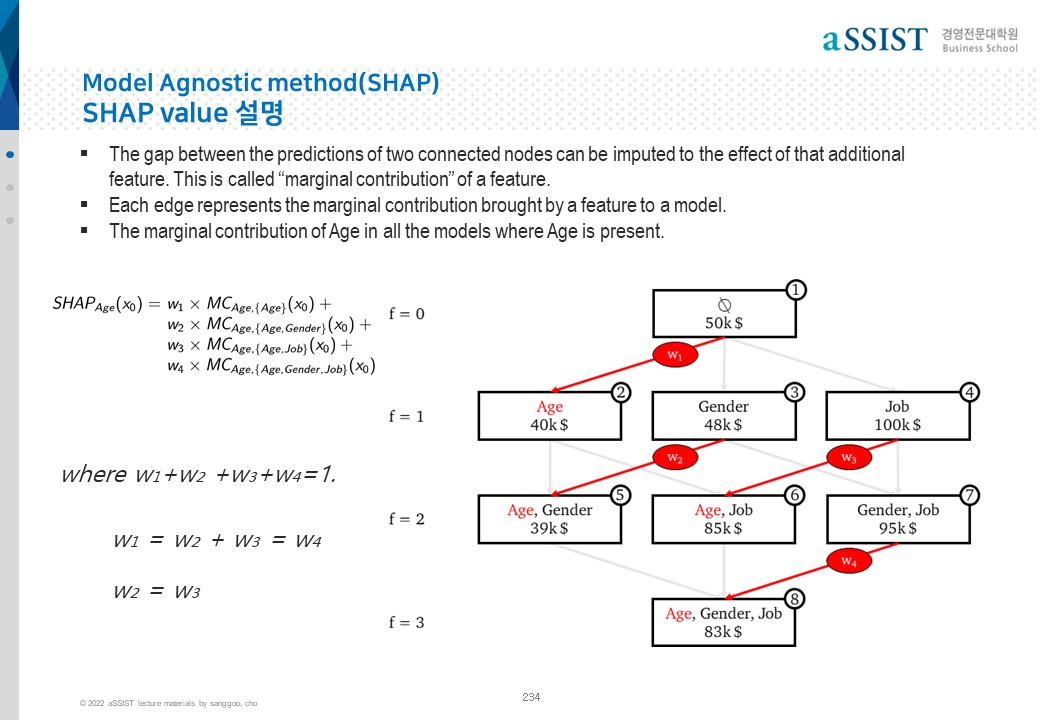

In [6]:
Image(filename=dir_path + '/슬라이드234.jpg', width=width, height=height)

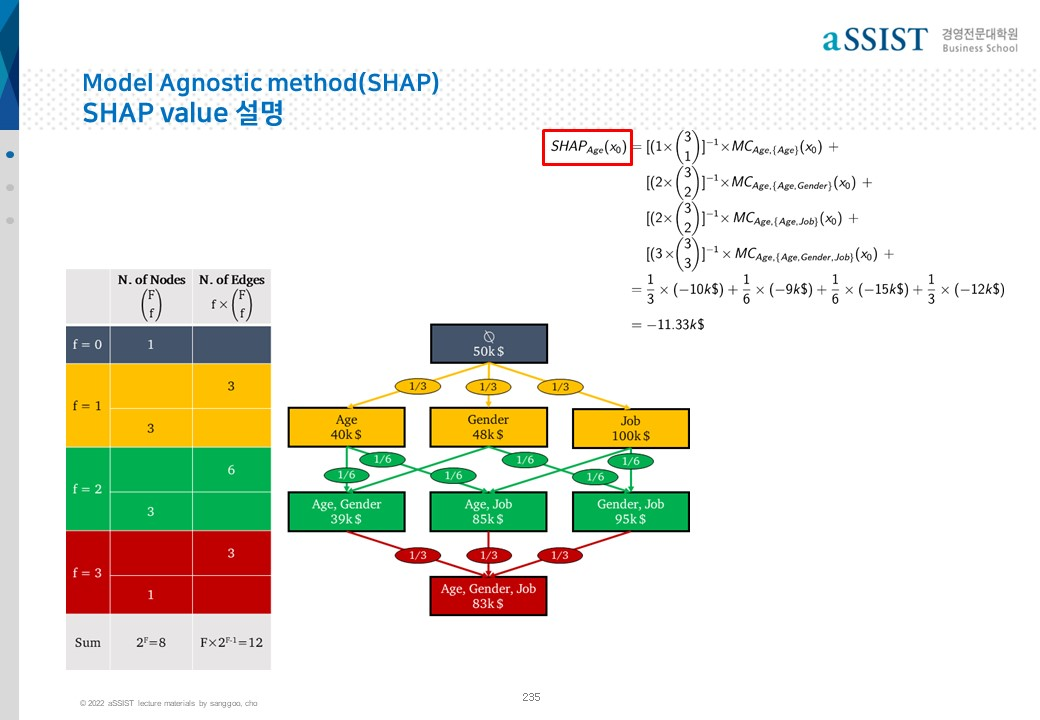

In [7]:
Image(filename=dir_path + '/슬라이드235.jpg', width=width, height=height)

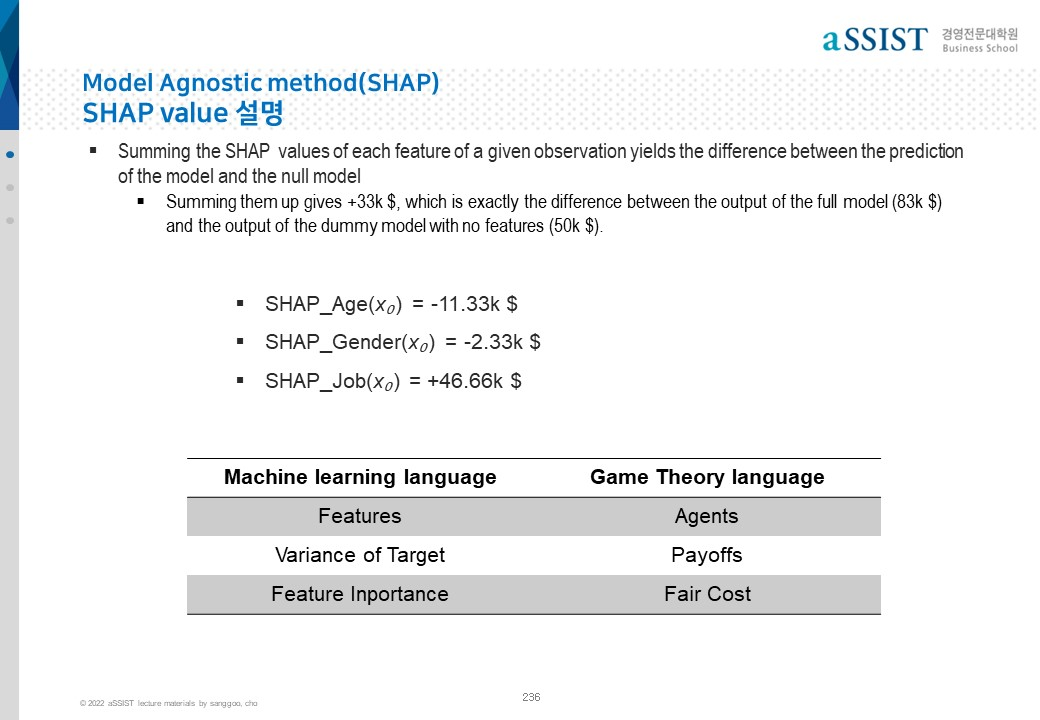

In [8]:
Image(filename=dir_path + '/슬라이드236.jpg', width=width, height=height)

# 4.1  회귀생성 모델(Regression)

In [9]:
import xgboost
import shap
# train an XGBoost model
X, y = shap.datasets.boston()
X.head()
y[0:10]

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33


array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9])

In [10]:
model = xgboost.XGBRegressor().fit(X, y)
explainer = shap.Explainer(model) # explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap_values[0]

.values =
array([-4.2850167e-01, -6.6636719e-02,  7.7860229e-02, -1.5295845e-03,
       -7.2922713e-01, -2.1700280e+00,  1.9213372e-01, -4.1425934e-01,
       -4.9156108e-01, -4.7296646e-01,  2.5669456e-01, -5.3907130e-02,
        5.7883248e+00], dtype=float32)

.base_values =
22.532942

.data =
array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [11]:
np.mean(model.predict(X)) # 모델의 예측 값
model.predict(X)[0] # 모델 예측 값의 평균
X.head(1) # 입력변수 실제 값
y[0] # target 실제 값

22.532934

24.019339

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98


24.0

## 1. 개별 자료의 예측 SHAP Value 시각화
### 1.1 폭포형태(waterfall)
- 입력변수의 색깔 : red는 양의 영향, blue는 음의 방향으로 영향
- 입력변수의 색깔의 길이 : red는 양의 영향 크기, blue는 음의 방향으로 영향 크기
- 첫번째 iinstance의 모델 예측 값 24.019, (f(x))와 모델 예측 평균 22.243, (E[f(X)])

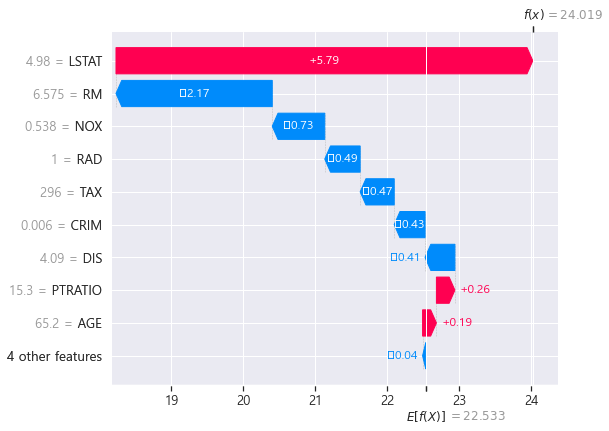

24.019330384342773

In [12]:
shap.plots.waterfall(shap_values[0])
shapvalues= np.array([-4.2850167e-01, -6.6636719e-02,  7.7860229e-02, -1.5295845e-03,
                      -7.2922713e-01, -2.1700280e+00,  1.9213372e-01, -4.1425934e-01,
                      -4.9156108e-01, -4.7296646e-01,  2.5669456e-01, -5.3907130e-02, 5.7883248e+00])
np.sum(shapvalues) + np.mean(model.predict(X)) 

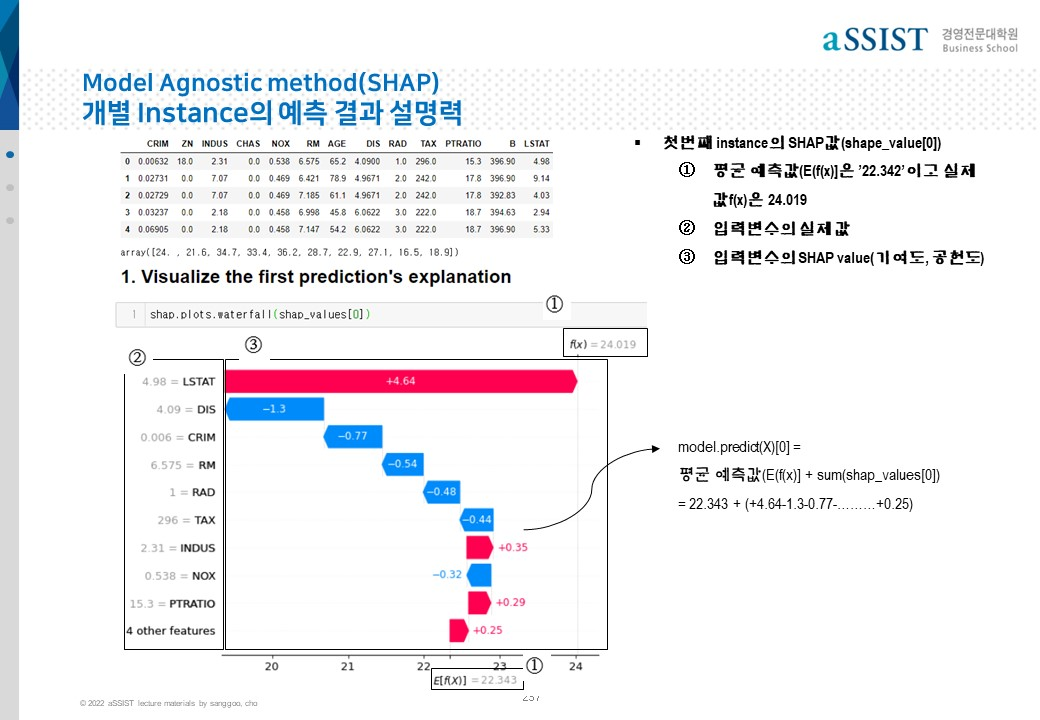

In [13]:
Image(filename=dir_path + '/슬라이드237.jpg', width=width, height=height)

### 2. 수평선 형태
- deeplearning의 경우 DeepExplainer를 적용하면 가능

#### Use Case
- SHAP provides multiple explainers for different kind of models.
     * TreeExplainer: Support XGBoost, LightGBM, CatBoost and scikit-learn models by Tree SHAP.
     * DeepExplainer (DEEP SHAP): Support TensorFlow and Keras models by using DeepLIFT and Shapley values.
     * GradientExplainer: Support TensorFlow and Keras models.
     * KernelExplainer (Kernel SHAP): Applying to any models by using LIME and Shapley values.

In [14]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(X)
shap_values[0]
shap.initjs()
shap.plots.force(explainer.expected_value, shap_values[0])

array([-4.2850167e-01, -6.6636719e-02,  7.7860229e-02, -1.5295845e-03,
       -7.2922713e-01, -2.1700280e+00,  1.9213372e-01, -4.1425934e-01,
       -4.9156108e-01, -4.7296646e-01,  2.5669456e-01, -5.3907130e-02,
        5.7883248e+00], dtype=float32)

## 2. 전체 자료(특성변수)의 SHAP value 시각화

If we take many force plot explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [15]:
shap.force_plot(explainer.expected_value, shap_values) # shap.force_plot(explainer.expected_value, shap_values, X)

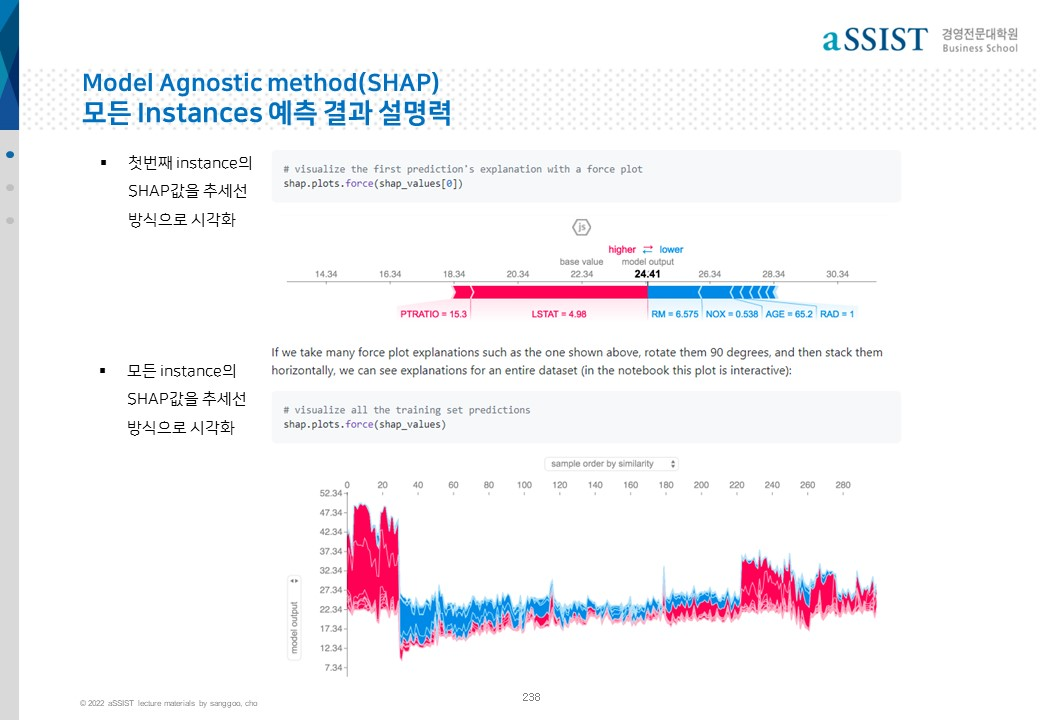

In [16]:
Image(filename=dir_path + '/슬라이드238.jpg', width=width, height=height)

Visualize the sub set of dataset

In [17]:
shap.force_plot(explainer.expected_value, shap_values[:1,:])
shap_values[:1,:]; X.iloc[:1,:]

array([[-4.2850167e-01, -6.6636719e-02,  7.7860229e-02, -1.5295845e-03,
        -7.2922713e-01, -2.1700280e+00,  1.9213372e-01, -4.1425934e-01,
        -4.9156108e-01, -4.7296646e-01,  2.5669456e-01, -5.3907130e-02,
         5.7883248e+00]], dtype=float32)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0,296.0,15.3,396.9,4.98


In [18]:
shap.force_plot(explainer.expected_value, shap_values[88:89,:], X.iloc[88:89,:])
shap_values[88:89,:]; X.iloc[88:89,:]

array([[-0.8317494 , -0.01641001,  0.00609174, -0.00422977,  0.24812706,
         1.7861861 , -1.4428022 , -0.00217092, -0.20806363, -0.08527828,
        -0.31793472, -0.13634086,  2.1391578 ]], dtype=float32)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
88,0.0566,0.0,3.41,0.0,0.489,7.007,86.3,3.4217,2.0,270.0,17.8,396.9,5.5


In [19]:
shap.force_plot(explainer.expected_value, shap_values[:89,:], X.iloc[:89,:])

### 모든 데이터(features, targets)의 SHAP value

In [20]:
data = pd.DataFrame(shap_values, columns = X.columns)
data['SUM'] = data.sum(1)  # 특성 변수의 SHAP values
data['f(x)'] = model.predict(X)
data['E[f(x)]'] = np.mean(model.predict(X))
data['SUM + E[f(x)]'] = data['SUM'] + data['E[f(x)]']
data

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,SUM,f(x),E[f(x)],SUM + E[f(x)]
0,-0.428502,-0.066637,0.077860,-0.001530,-0.729227,-2.170028,0.192134,-0.414259,-0.491561,-0.472966,0.256695,-0.053907,5.788325,1.486397,24.019339,22.532934,24.019331
1,-0.159478,-0.039209,-0.096550,-0.000803,0.180373,-1.750252,-0.246799,-0.948719,-0.091274,0.210134,0.460189,0.001291,1.547877,-0.933222,21.599709,22.532934,21.599712
2,-0.062259,-0.039241,-0.163524,-0.002156,0.627054,3.956776,0.289584,-0.936786,-0.065633,0.409528,0.036114,0.209845,7.915174,12.174474,34.707420,22.532934,34.707409
3,0.252239,-0.007029,0.323649,-0.003503,0.543809,1.614911,0.197332,-1.169711,-0.060547,1.086732,-0.138008,0.192880,8.041687,10.874443,33.407383,22.532934,33.407379
4,0.642628,-0.005839,0.339306,-0.006831,0.367894,4.457727,0.441548,-0.360033,-0.049200,2.044360,-0.134221,0.256531,5.662515,13.656385,36.189331,22.532934,36.189320
5,-0.187336,-0.003823,0.804396,-0.006773,0.312594,-2.592569,0.425990,-0.440094,-0.052098,2.308819,0.482191,0.128422,4.988302,6.168020,28.700958,22.532934,28.700954
6,0.537942,0.007803,-0.111838,0.000335,0.265768,-1.925942,0.389314,-0.120972,0.107012,-0.129494,1.261721,0.251481,-0.271796,0.261334,22.794266,22.532934,22.794268
7,2.648197,0.036083,-0.018658,-0.001318,0.668878,-0.889661,0.238201,1.624551,0.102924,-0.024000,1.904207,0.460923,-2.292788,4.457541,26.990475,22.532934,26.990475
8,0.814756,-0.022959,-0.103666,-0.002487,0.663069,-2.482352,-0.697040,-1.220403,0.044770,-0.177013,1.448364,-0.067413,-4.225953,-6.028327,16.504614,22.532934,16.504608
9,0.938125,-0.001270,-0.080140,-0.000685,0.331474,-1.919770,-0.408627,-1.357155,0.096656,-0.223561,1.075577,0.392982,-2.469731,-3.626127,18.906811,22.532934,18.906807


### SHAP summary plot 해석하기

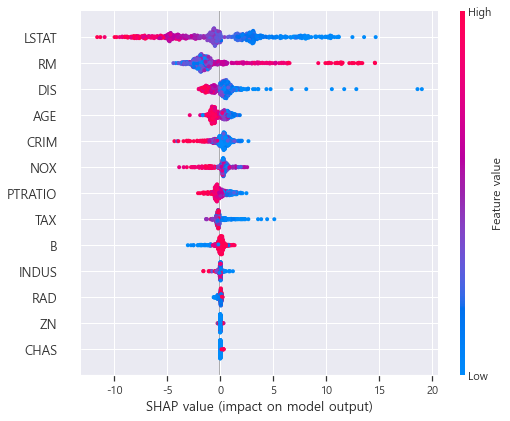

In [21]:
shap.summary_plot(shap_values, X)

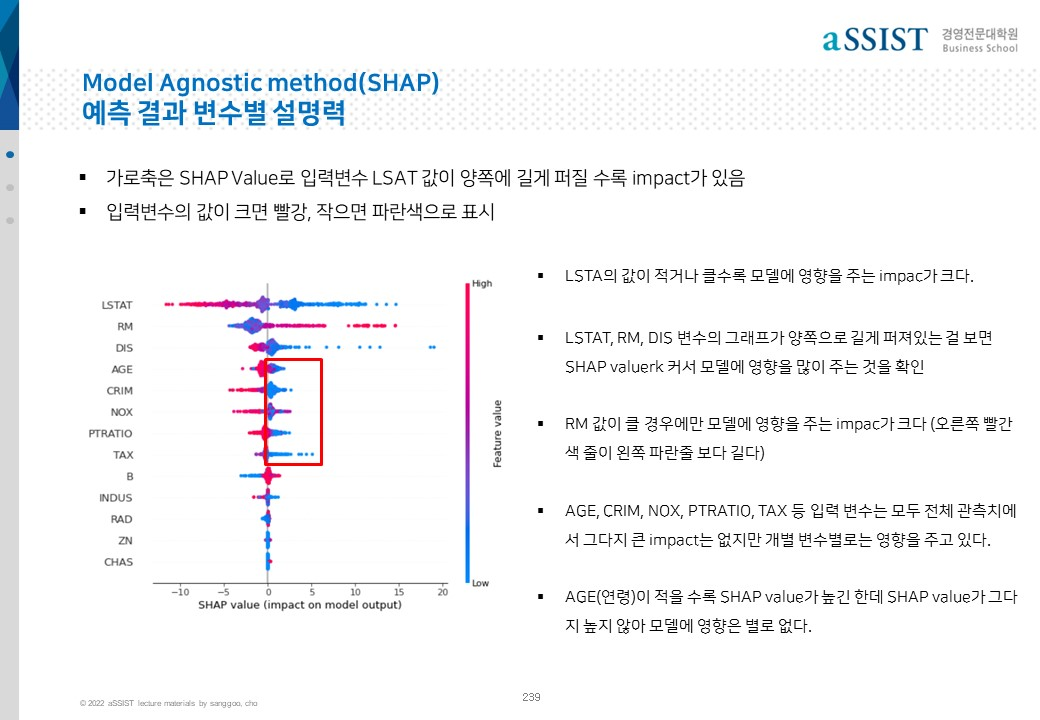

In [23]:
Image(filename=dir_path + '/슬라이드239.jpg', width=width, height=height)

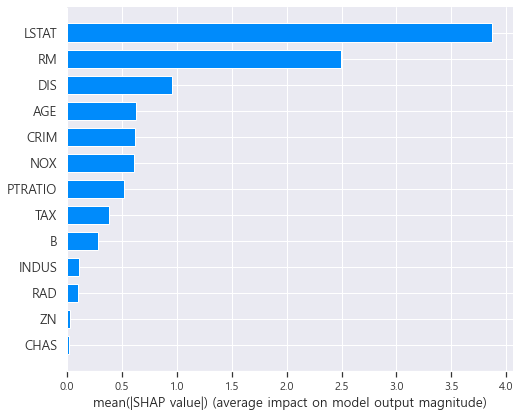

In [22]:
shap.summary_plot(shap_values, X, plot_type="bar")

# 4.2  분류 모델(Classification)
https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/scatter.html (그림그리기는 여기를)

The classic UCI adult income dataset (which is a classification task to predict if people made over \$50k in the 90s).

In [27]:
X,y = shap.datasets.adult()
X.head()
X.shape
y

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5


(32561, 12)

array([False, False, False, ..., False, False,  True])

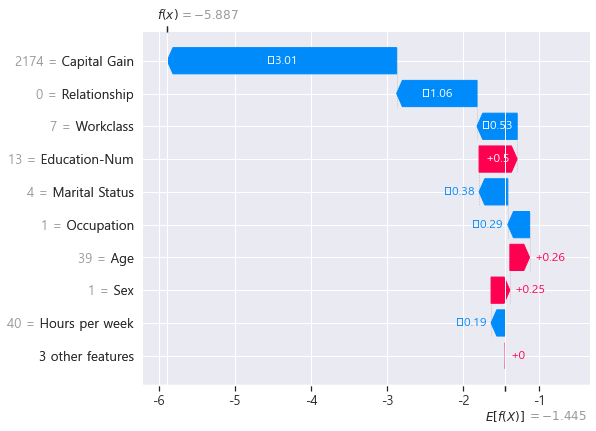

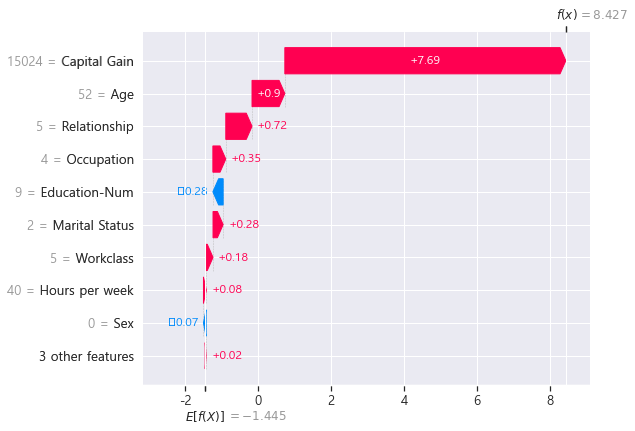

In [44]:
model = xgboost.XGBClassifier(eval_metric='mlogloss').fit(X, y)
explainer = shap.Explainer(model) # explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[32560])

In [46]:
shap_values[0]

.values =
array([ 0.25884783, -0.52761453,  0.50065815, -0.37688422, -0.28697187,
       -1.0563128 ,  0.0174993 ,  0.24717885, -3.0146728 , -0.04383661,
       -0.18832082,  0.02812828], dtype=float32)

.base_values =
-1.4446166

.data =
array([3.900e+01, 7.000e+00, 1.300e+01, 4.000e+00, 1.000e+00, 0.000e+00,
       4.000e+00, 1.000e+00, 2.174e+03, 0.000e+00, 4.000e+01, 3.900e+01])

In [63]:
explainer = shap.TreeExplainer(model) 
shap_values = explainer.shap_values(X)
shap.force_plot(explainer.expected_value, shap_values[:89,:], X.iloc[:89,:])

In [52]:
data = pd.DataFrame(shap_values, columns = X.columns)
data['SUM'] = data.sum(1)  # 특성 변수의 SHAP values
data['f(x)'] = model.predict(X)
data['E[f(x)]'] = -1.4446166
data['SUM + E[f(x)]'] = data['SUM'] + data['E[f(x)]']
data.sample(10, random_state=111).iloc[:, 10:20]

,Hours per week,Country,SUM,f(x),E[f(x)],SUM + E[f(x)]
10636,-0.065793,0.023830,-0.296786,False,-1.444617,-1.741403
30981,-0.162776,0.010148,0.377558,False,-1.444617,-1.067059
28741,-0.669212,-0.469515,-1.689182,False,-1.444617,-3.133798
439,-0.077744,0.010294,1.889334,True,-1.444617,0.444717
6046,-0.881459,0.017454,-3.294894,False,-1.444617,-4.739511
611,-0.230676,0.012960,-3.792003,False,-1.444617,-5.236620
1197,0.175349,0.023306,2.373122,True,-1.444617,0.928505
12367,-0.230342,-0.303656,-3.407349,False,-1.444617,-4.851965
20014,-0.044669,0.025787,2.706327,True,-1.444617,1.261711
7913,-0.028666,0.009797,-2.581276,False,-1.444617,-4.025893


<AxesSubplot:xlabel='f(x)', ylabel='SUM + E[f(x)]'>

0.0004469910034179403

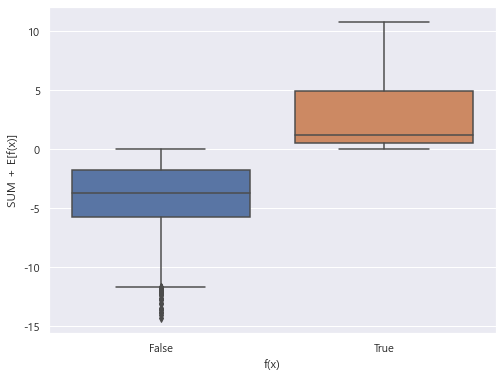

In [56]:
plt.rcParams['figure.figsize'] = (8,6)
sns.boxplot(x='f(x)', y='SUM + E[f(x)]', data=data)
data[data['f(x)'] == True]['SUM + E[f(x)]'].min()

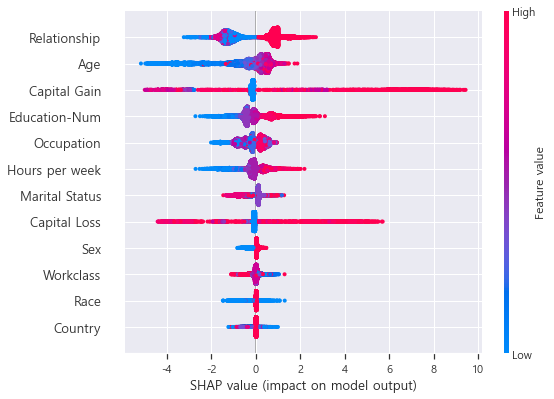

In [64]:
shap.summary_plot(shap_values, X)

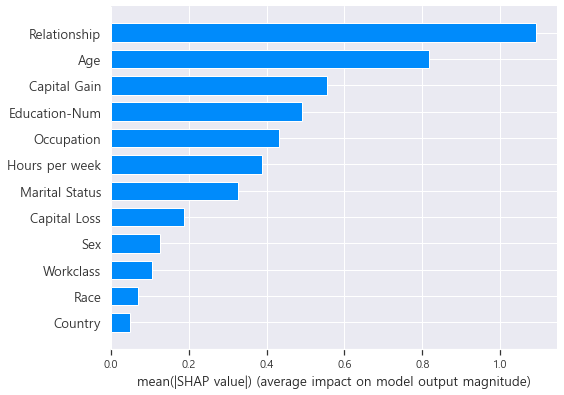

In [65]:
shap.summary_plot(shap_values, X, plot_type="bar")

### Simple dependence scatter plot
- A dependence scatter plot shows the effect a single feature has on the predictions made by the model. 
- In this example the log-odds of making over 50k increases significantly between age 20 and 40.

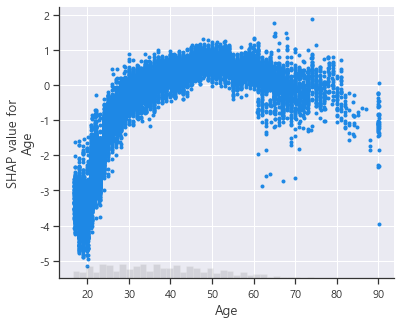

In [71]:
explainer = shap.Explainer(model) # explainer = shap.Explainer(model, X)
shap_values = explainer(X)
shap.plots.scatter(shap_values[:,"Age"])

- Each dot is a single prediction (row) from the dataset.
- The x-axis is the value of the feature (from the X matrix, stored in shap_values.data).
- The y-axis is the SHAP value for that feature (stored in shap_values.values), which represents how much knowing that feature’s value changes the output of the model for that sample’s prediction. For this model the units are log-odds of making over 50k annually.
- The light grey area at the bottom of the plot is a histogram showing the distribution of data values.

### Using color to highlight interaction effects

- The vertical dispersion in the plot above shows that the same value for the Age feature can have a different impact on the model's output for different people. This means there are non-linear interaction effects in the model between Age and other features (otherwise the scatter plot would perfectly follow the line given by shap.plots.partial_dependence).

- To show which feature may be driving these interaction effects we can color our Age dependence scatter plot by another feature. 
- If we pass the entire Explanation object to the color parameter then the scatter plot attempts to pick out the feature column with the strongest interaction with Age. If an interaction effect is present between this other feature and the feature we are plotting it will show up as a distinct vertical pattern of coloring. 
- For the example below, 20-year-olds with a high level of education are less likely make over \$50k than 20-year-olds with a low level of education. This suggests an interaction effect between Education-Num and Age.

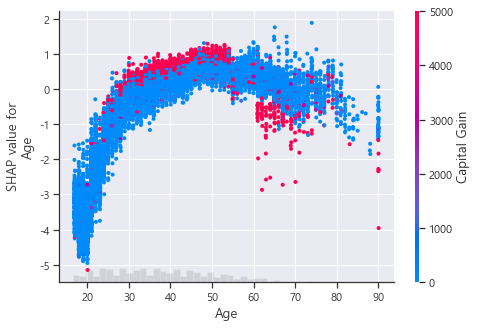

In [72]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values)

To explicitly control which feature is used for coloring you can pass a specific feature column to the color parameter.

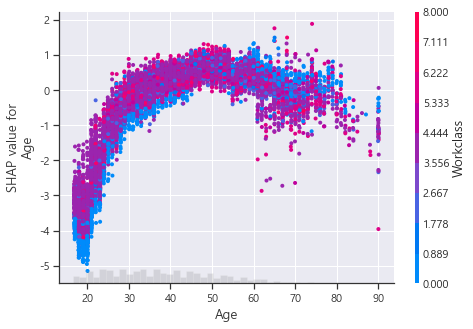

In [73]:
shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:,"Workclass"])

In the plot above we see that the Workclass feature is encoded with a number for the sake of the XGBoost model. When plotting though we often would rather use the original string values before they were categorically encoded. To do this we can set the .display_data property of the Explanation object to a parallel version of the data we would like displayed in plots.

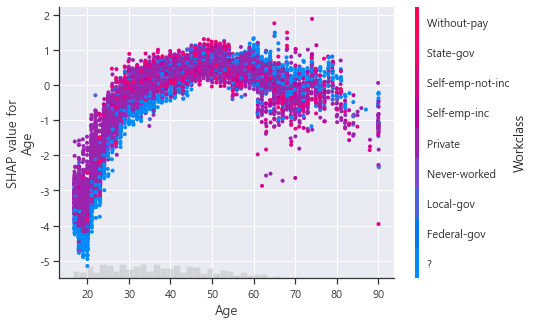

In [74]:
X_display,y = shap.datasets.adult(display=True)
shap_values.display_data = X_display.values

shap.plots.scatter(shap_values[:, "Age"], color=shap_values[:,"Workclass"])

### Exploring different interaction colorings
- we can use shap.approximate_interactions to guess which features may interact with age. 
-  we can make plots colored by each of the top three possible interacting features

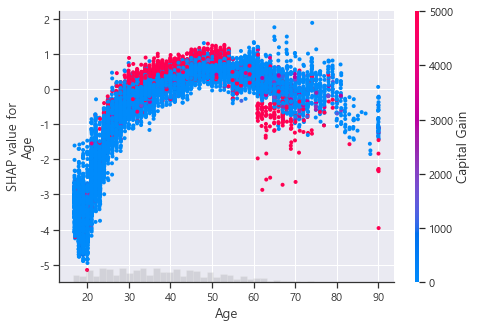

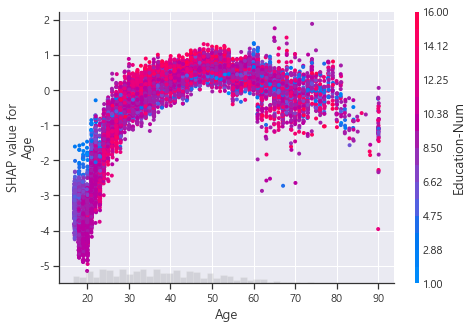

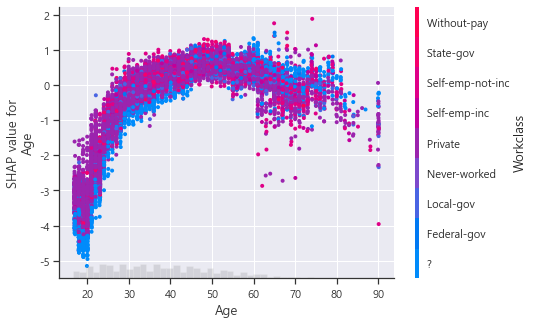

In [75]:
inds = shap.utils.potential_interactions(shap_values[:, "Age"], shap_values)
for i in range(3):
    shap.plots.scatter(shap_values[:,"Age"], color=shap_values[:,inds[i]])

### Using global feature importance orderings
Sometimes we don’t know the name or index of the feature we want to plot, we just want to plot the most important features. To do that we can use the dot-chaining capability of the Explanation object to compute a measure of global feature importance, sort by that measure (descending), and then pick out the top feature (which in this case is Age):

# End